测试数据和训练数据分组，数据分batch

In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

In [2]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

54
15
7


定义交叉注意力机制

In [2]:
import torch
import torch.nn as nn

class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(CrossAttention, self).__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.value_dim = value_dim
        
        self.query_linear = nn.Linear(query_dim, query_dim)
        self.key_linear = nn.Linear(key_dim, query_dim)
        self.value_linear = nn.Linear(value_dim, query_dim)

    def forward(self, query, key, value):
        # 计算查询序列的注意力权重
        query_emb = self.query_linear(query)
        key_emb = self.key_linear(key)
        attention_weights = torch.bmm(query_emb, key_emb.transpose(1, 2))
        attention_weights = torch.softmax(attention_weights, dim=-1)
       
        # 根据注意力权重对值序列进行加权求和
        value_emb = self.value_linear(value)
        attended_values = torch.bmm(attention_weights, value_emb)

        return attended_values


定义FFT-CNN-Transformer-CrossAttention 网络架构

In [3]:
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer

class FCNNTransformerCrossAttModel(nn.Module):
    def __init__(self, batch_size, timeconv_arch, spaceconv_arch, timeinput_dim, spaceinput_dim, output_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.5,input_channels=1):
        """
        分类任务  params:
        batch_size          : 批次量大小
        timeconv_arch       : 一维时域信号 cnn 网络结构
        spaceconv_arch      : 一维频域信号 cnn 网络结构
        timeinput_dim       : 时域卷积输入维度
        spaceinput_dim      : 频域卷积输入维度
        output_dim          : 输出的维度,类别数
        hidden_dim          : 注意力维度
        num_layers          : Transformer编码器层数
        num_heads           : 多头注意力头数
        dropout_rate        : 随机丢弃神经元的概率
        input_channels      : CNN输入维度(通道数)
        """
        super().__init__()
         # 批次量大小
        self.batch_size = batch_size
        # time-cnn参数
        self.timeconv_arch = timeconv_arch  # 网络结构
        self.timeinput_channels = input_channels  # 输入通道数
        self.timefeatures = self.timecnnmake_layers()
        # space-cnn参数
        self.spaceconv_arch = spaceconv_arch  # 网络结构
        self.spaceinput_channels = input_channels  # 输入通道数
        self.spacefeatures = self.spacecnnmake_layers()

        # Transformer编码器
        self.hidden_dim = hidden_dim
        # Time Transformer layers
        self.timetransformer = TransformerEncoder(
            TransformerEncoderLayer(timeinput_dim, num_heads, hidden_dim, dropout=dropout_rate, batch_first=True),
            num_layers
        )
        # Space Transformer layers
        self.spacetransformer = TransformerEncoder(
            TransformerEncoderLayer(spaceinput_dim, num_heads, hidden_dim, dropout=0.5, batch_first=True),
            num_layers
        )

        # 交叉注意力模块
        self.cross_attention = CrossAttention(timeconv_arch[-1][-1], spaceconv_arch[-1][-1], spaceconv_arch[-1][-1])  # q, k ,v 维度数
       
        # 自适应平均池化
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # 定义全连接层
        self.classifier = nn.Linear(timeconv_arch[-1][-1], output_dim) 
     
    
    # VGG卷积池化结构
    def timecnnmake_layers(self):
        layers = []
        for (num_convs, out_channels) in self.timeconv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.timeinput_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.timeinput_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.BatchNorm1d(out_channels))  # 添加批量归一化层
        return nn.Sequential(*layers)

    def spacecnnmake_layers(self):
        layers = []
        for (num_convs, out_channels) in self.spaceconv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.spaceinput_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.spaceinput_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.BatchNorm1d(out_channels))  # 添加批量归一化层
        return nn.Sequential(*layers)

    
    def forward(self, input_seq): 
        # 时域特征 卷积池化处理
        time_input = input_seq.view(self.batch_size, 1, 1024)  
        # CNN 1d卷积 网络输入 [batch,H_in, seq_length]
        time_features = self.timefeatures(time_input) 
        # print(time_features.size())   # torch.Size([32, 128, 129])
        # 调换维度[B, D, L] --> [B, L, D]
        time_features = time_features.permute(0,2,1)
        # Time-Transformer 处理
        # 在PyTorch中，transformer模型的性能与batch_first参数的设置相关。
        # 当batch_first为True时，输入的形状应为(batch, sequence, feature)，这种设置在某些情况下可以提高推理性能。
        time_transformer_output = self.timetransformer(time_features)  #  torch.Size([32, 129, 128])
       
        # 频域特征 卷积池化处理
        # 快速傅里叶变换
        fft_result = torch.fft.rfft(input_seq, dim=1)
        magnitude_spectrum = torch.abs(fft_result[:, :512])  #[256, 512]
        # 归一化操作
        # normalized_spectrum = F.normalize(magnitude_spectrum, p=2, dim=1)
        space_input = magnitude_spectrum.view(self.batch_size, 1, -1)  # torch.Size([32, 1, 512])
        # CNN 1d卷积 网络输入 [batch,H_in, seq_length]
        space_features = self.spacefeatures(space_input)   # torch.Size([32, 64, 65])
        # print(space_features.size())  # torch.Size([32, 64, 65])
        # 调换维度[B, D, L] --> [B, L, D]
        space_features = space_features.permute(0,2,1)
        # Space-Transformer 处理
        space__transformer_output = self.spacetransformer(space_features)  # torch.Size([32, 65, 64])
      
      
        # 注意力融合
        # 交叉注意力机制 cross_attention
        query = time_transformer_output
        key = space__transformer_output
        value = space__transformer_output
        cross_attention_features = self.cross_attention(query, key, value)   # torch.Size([32, 128, 129])
        # print(cross_attention_features.size())   # torch.Size([32, 128, 129])

        # 自适应平均池化
        x = self.adaptive_pool(cross_attention_features.transpose(1, 2))  # torch.Size([32, 128, 1])
        # print(x.size()) # torch.Size([32, 128, 1])
        flat_tensor = x.reshape(self.batch_size, -1)
        outputs = self.classifier(flat_tensor) # torch.Size([32, 10] 
        return outputs

输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([64, 1024])    torch.Size([64])

In [4]:
# 定义 FCNNTransformerCrossAttModel 模型参数
# batch_size = 64
# 时域 卷积参数
timeconv_arch = ((2, 32), (2, 64), (2, 128))  # CNN 层卷积池化结构  类似VGG
# 频域 卷积参数
spaceconv_arch =  ((2, 16), (2, 32), (2, 64))  # CNN 层卷积池化结构  类似VGG
# Transformer参数
timeinput_dim = 128  # 时域卷积输入维度
spaceinput_dim = 64  # 频域卷积输入维度
hidden_dim = 128  # 注意力维度
output_dim  = 10  # 输出维度 十分类
num_layers = 2   # 编码器层数
num_heads = 2   # 多头注意力头数

model = FCNNTransformerCrossAttModel(batch_size, timeconv_arch, spaceconv_arch, timeinput_dim, spaceinput_dim, output_dim, hidden_dim, num_layers, num_heads)  
# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    96
    32
  3072
    32
    32
    32
  6144
    64
 12288
    64
    64
    64
 24576
   128
 49152
   128
   128
   128
    48
    16
   768
    16
    16
    16
  1536
    32
  3072
    32
    32
    32
  6144
    64
 12288
    64
    64
    64
 49152
   384
 16384
   128
 16384
   128
 16384
   128
   128
   128
   128
   128
 49152
   384
 16384
   128
 16384
   128
 16384
   128
   128
   128
   128
   128
 12288
   192
  4096
    64
  8192
   128
  8192
    64
    64
    64
    64
    64
 12288
   192
  4096
    64
  8192
   128
  8192
    64
    64
    64
    64
    64
 16384
   128
  8192
   128
  8192
   128
  1280
    10
______
421082


In [7]:
print(model)

FCNNTransformerCrossAttModel(
  (timefeatures): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU(inplace=True)
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (15): ReLU(inplace=True)
    (16): Conv1d(128, 128, kernel_size=(3,), st

注意调整参数，
1. 可以适当增加CNN 层数 和每层神经元个数，微调学习率；
2. 更改 Transformer编码器维度和层数，增加更多的 epochs,  （注意防止过拟合）
3. 增加注意力层维度数

Epoch:  1 train_Loss: 0.83960234 train_Accuracy:0.6655
Epoch:  1 val_Loss:0.74984299,  validate_Acc:0.7115
Epoch:  2 train_Loss: 0.49071194 train_Accuracy:0.7943
Epoch:  2 val_Loss:0.34068917,  validate_Acc:0.8427
Epoch:  3 train_Loss: 0.39035052 train_Accuracy:0.8163
Epoch:  3 val_Loss:0.35587853,  validate_Acc:0.8594
Epoch:  4 train_Loss: 0.70154379 train_Accuracy:0.7323
Epoch:  4 val_Loss:1.15140336,  validate_Acc:0.5573
Epoch:  5 train_Loss: 0.74147149 train_Accuracy:0.6198
Epoch:  5 val_Loss:0.57910341,  validate_Acc:0.7000
Epoch:  6 train_Loss: 0.58567960 train_Accuracy:0.6956
Epoch:  6 val_Loss:0.57307146,  validate_Acc:0.6771
Epoch:  7 train_Loss: 0.50834374 train_Accuracy:0.7266
Epoch:  7 val_Loss:0.44375259,  validate_Acc:0.7802
Epoch:  8 train_Loss: 0.54271046 train_Accuracy:0.7483
Epoch:  8 val_Loss:0.53681888,  validate_Acc:0.7760
Epoch:  9 train_Loss: 0.46556511 train_Accuracy:0.7836
Epoch:  9 val_Loss:0.33027636,  validate_Acc:0.8229
Epoch: 10 train_Loss: 0.36573931 trai

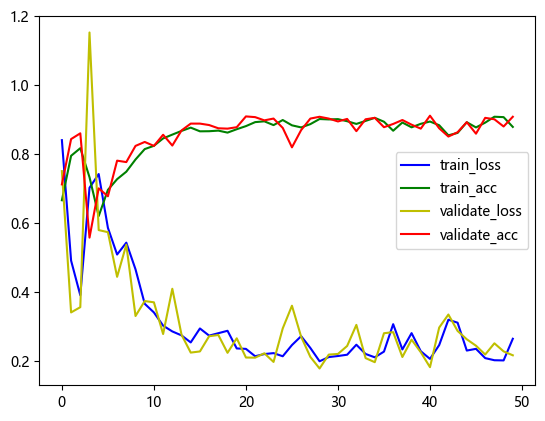

best_accuracy : 0.9104166666666667


In [8]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_cnn_transformer_catt.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn_transformer_catt.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)

# batch_size = 64
epochs = 50
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [10]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_cnn_transformer_catt.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.4466    1.0000    0.6174        46
           1     1.0000    0.9565    0.9778        46
           2     1.0000    0.7907    0.8831        43
           3     0.9556    0.9348    0.9451        46
           4     0.9057    1.0000    0.9505        48
           5     0.8654    1.0000    0.9278        45
           6     1.0000    0.8333    0.9091        42
           7     0.8627    1.0000    0.9263        44
           8     0.4667    0.1591    0.2373        44
           9     0.6250    0.2273    0.3333        44

    accuracy                         0.7946       448
   macro avg     0.8128    0.7902    0.7708       448
weighted avg     0.8123    0.7946    0.7729       448



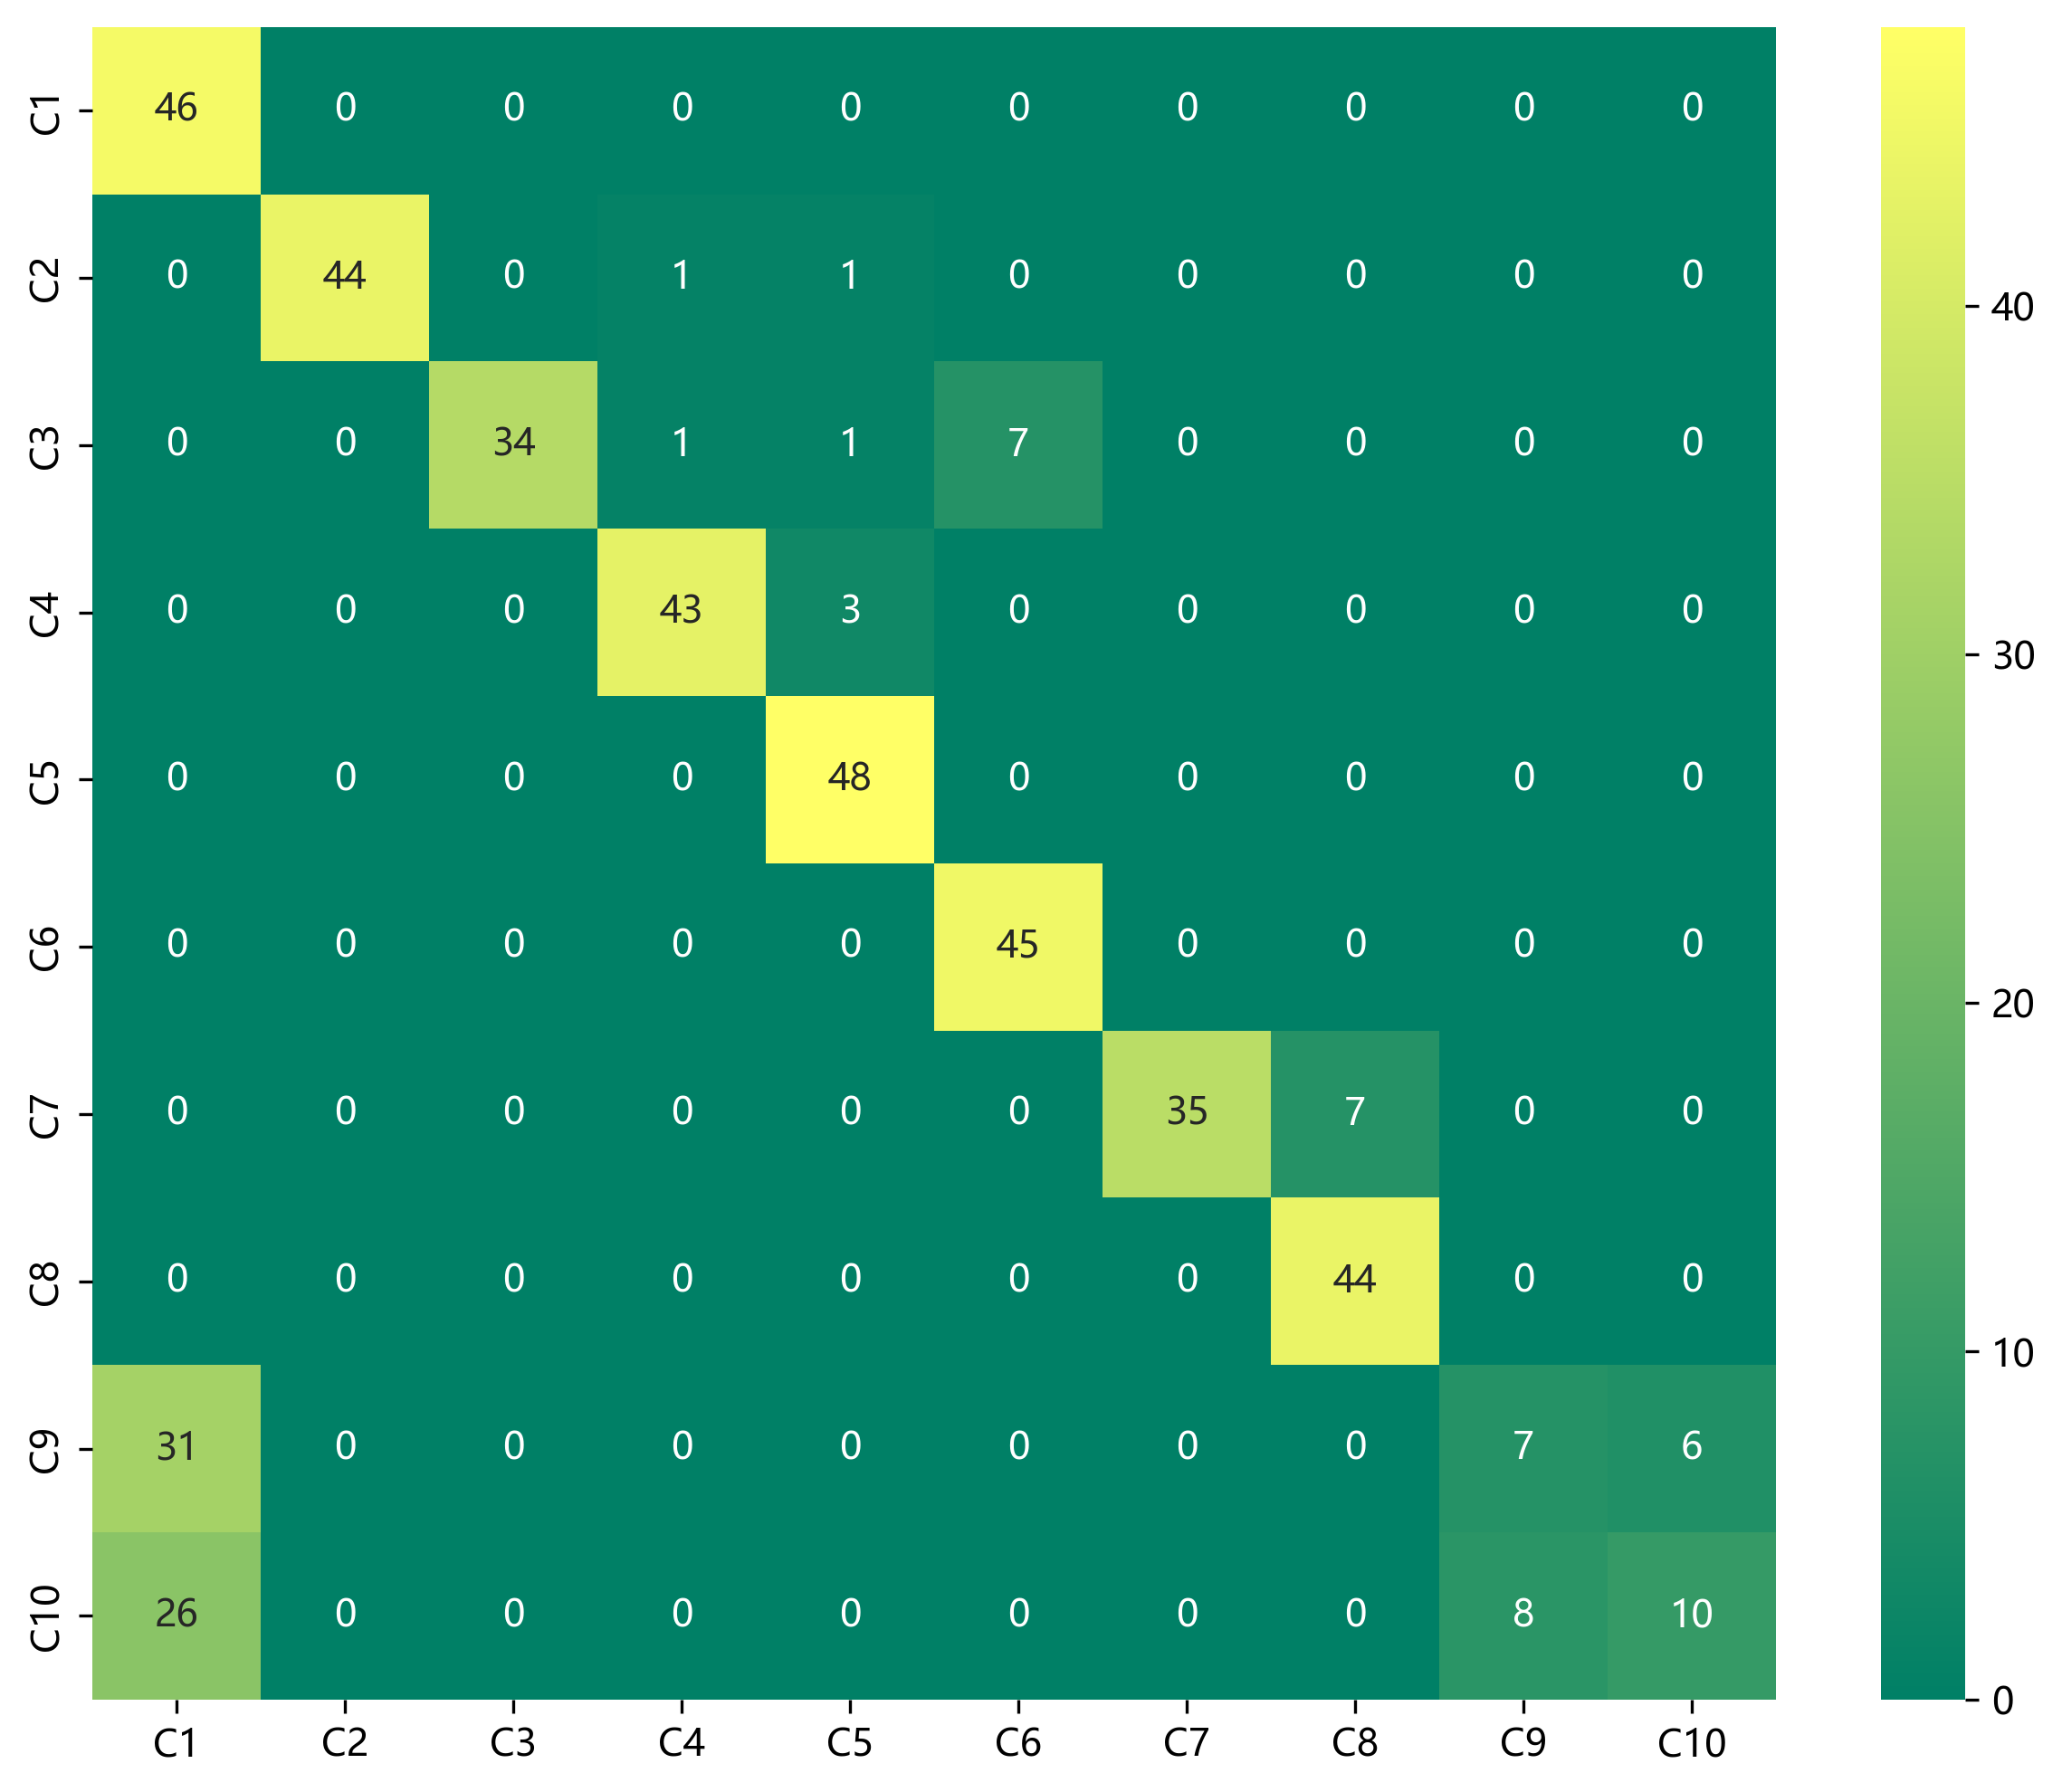

In [11]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()